# Restaurant Recommender System

Data Source:
https://archive-beta.ics.uci.edu/dataset/232/restaurant+consumer+data


Author: Yucian Hong

In [5]:
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import SVD
from surprise.dataset import Reader, Dataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

## preprocessing

In [6]:
# list of input files
## for input file descriptions, please see README in the data source link
restaurants = ['chefmozaccepts.csv', 'chefmozcuisine.csv', 
'chefmozhours4.csv','chefmozparking.csv','geoplaces2.csv']
ratings = ['rating_final.csv']
users = ['usercuisine.csv','userpayment.csv','userprofile.csv']

In [7]:
# read csv files
place = [None]*(len(restaurants))

for i in range(len(restaurants)-1):
    place[i] = pd.read_csv(restaurants[i])
    
place[i+1] = pd.read_csv('geoplaces2.csv',encoding='latin-1')


user = [None]*(len(users))

for i in range(len(users)):
    user[i] = pd.read_csv(users[i])
    
rating = pd.read_csv('rating_final.csv')

In [8]:
# preview files

print('restaurants:')
for i in range(len(place)):
    print(restaurants[i])
    place[i].head(2)
    
print('users:')

for i in range(len(user)):
    print(users[i])
    user[i].head(2)

print('rating:')
print('rating_final.csv')
rating.head(2)
    

restaurants:
chefmozaccepts.csv


,placeID,Rpayment
0,135110,cash
1,135110,VISA


chefmozcuisine.csv


,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian


chefmozhours4.csv


,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;


chefmozparking.csv


,placeID,parking_lot
0,135111,public
1,135110,none


geoplaces2.csv


,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none


users:
usercuisine.csv


,userID,Rcuisine
0,U1001,American
1,U1002,Mexican


userpayment.csv


,userID,Upayment
0,U1001,cash
1,U1002,cash


userprofile.csv


,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87


rating:
rating_final.csv


,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1


In [9]:
# check column info and missing values
rating.info()
print('')
user[0].info()
print('')
user[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userID          1161 non-null   object
 1   placeID         1161 non-null   int64 
 2   rating          1161 non-null   int64 
 3   food_rating     1161 non-null   int64 
 4   service_rating  1161 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 45.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userID    330 non-null    object
 1   Rcuisine  330 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userID            138 non-null   

In [10]:
# check duplicate data
rating.duplicated(keep='last').shape[0]
print('no duplicated rows')

1161

no duplicated rows


## Exploratory analysis
### ratings

number of data points:


1161

number of users:


138

number of restaurants:


130

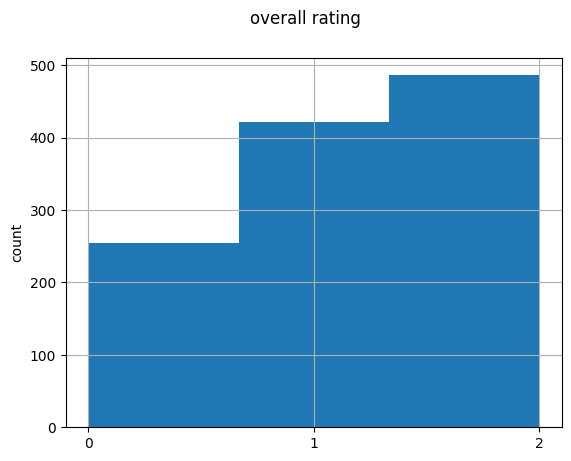

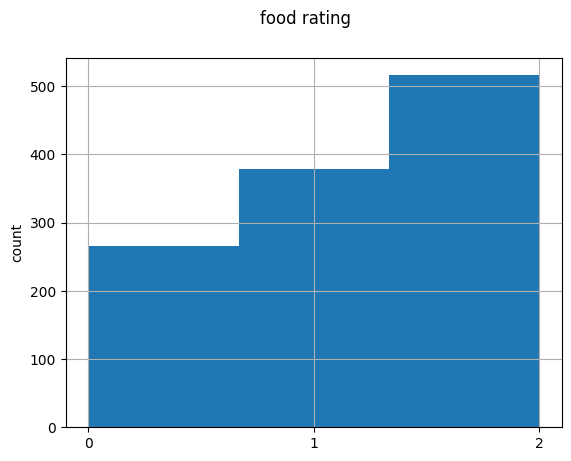

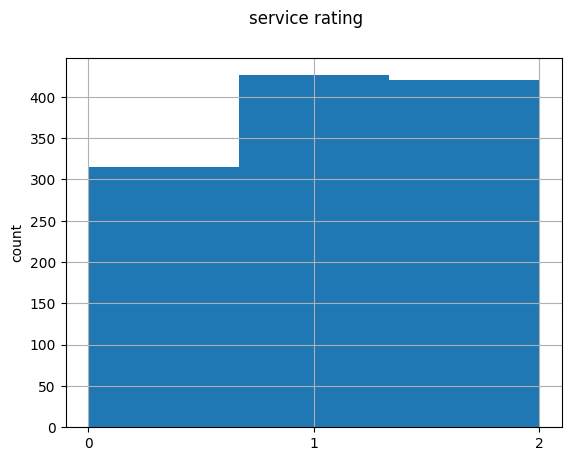

In [11]:
# preview column values of rating
print('number of data points:')
rating.shape[0]

print('number of users:')
rating.userID.nunique()

print('number of restaurants:')
rating.placeID.nunique()
print('')

_ = rating.rating.hist(bins=3)
_ = plt.suptitle("overall rating")
_ = plt.ylabel('count')
_ = plt.xticks([0,1,2])
plt.show()


_ = rating.food_rating.hist(bins=3)
_ = plt.suptitle("food rating")
_ = plt.ylabel('count')
_ = plt.xticks([0,1,2])
plt.show()

_ = rating.service_rating.hist(bins=3)
_ = plt.suptitle("service rating")
_ = plt.ylabel('count')
_ = plt.xticks([0,1,2])
plt.show()

### users

In [12]:
# summary of user cuisine preference
user[0].groupby('userID').count().sort_values(by='Rcuisine',ascending=False)

,Rcuisine
userID,
U1135,103
U1108,18
U1101,15
U1016,14
U1060,13
...,...
U1046,1
U1044,1
U1043,1


,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69
5,U1006,22.150000,-100.983000,true,social drinker,no preference,friends,car owner,single,independent,1989,variety,hard-worker,none,student,blue,75,medium,1.80
6,U1007,22.118464,-100.938256,false,casual drinker,informal,solitary,public,single,independent,1989,variety,thrifty-protector,Catholic,student,purple,60,low,1.59
7,U1008,22.122989,-100.923811,false,social drinker,formal,solitary,public,single,independent,1989,technology,hard-worker,Catholic,student,green,68,low,1.72
8,U1009,22.159427,-100.990448,false,abstemious,formal,family,on foot,single,kids,1991,variety,thrifty-protector,Catholic,student,green,75,medium,1.78
9,U1010,22.190889,-100.998669,false,social drinker,no preference,friends,car owner,married,kids,1987,technology,hard-worker,none,student,green,40,medium,1.67


Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height'],
      dtype='object')

count     138.000000
mean     1984.702899
std        14.655364
min      1930.000000
25%      1987.000000
50%      1989.000000
75%      1991.000000
max      1994.000000
Name: birth_year, dtype: float64

(125, 19)

(38, 19)

(13, 19)

<Axes: >

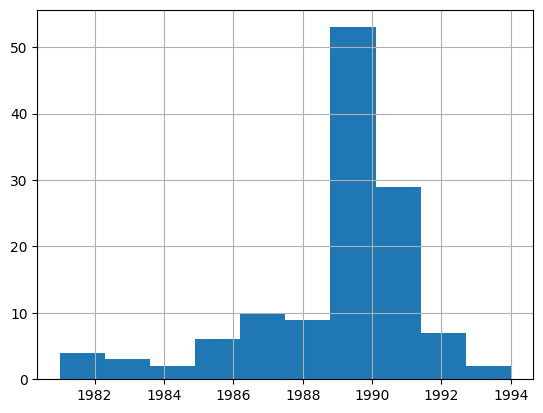

activity
student          113
professional      15
?                  7
unemployed         2
working-class      1
Name: count, dtype: int64

marital_status
single     122
married     10
?            4
widow        2
Name: count, dtype: int64

budget
medium    91
low       35
?          7
high       5
Name: count, dtype: int64

hijos
independent    113
kids            11
?               11
dependent        3
Name: count, dtype: int64

dress_preference
no preference    53
formal           41
informal         35
?                 5
elegant           4
Name: count, dtype: int64

ambience
family      70
friends     46
solitary    16
?            6
Name: count, dtype: int64

personality
hard-worker            61
thrifty-protector      58
hunter-ostentatious    12
conformist              7
Name: count, dtype: int64

drink_level
abstemious        51
casual drinker    47
social drinker    40
Name: count, dtype: int64

interest
variety         50
technology      36
none            30
eco-friendly    16
retro            6
Name: count, dtype: int64

color
blue      45
black     21
green     19
red       15
yellow    12
purple    11
white     11
orange     4
Name: count, dtype: int64

In [13]:
# summary of user profile
user[2].head(10)

# inspect columns
user[2].columns
user[2].birth_year.describe()

user[2][user[2].birth_year>1980].shape
user[2][user[2].birth_year>1990].shape
user[2][user[2].birth_year<1980].shape
user[2][user[2].birth_year>1980].birth_year.hist(bins=10)
plt.show()

user[2].activity.value_counts()
user[2].marital_status.value_counts()
user[2].budget.value_counts()
user[2].hijos.value_counts()


user[2].dress_preference.value_counts()
user[2].ambience.value_counts()
user[2].personality.value_counts()
user[2].drink_level.value_counts()
user[2].interest.value_counts()
user[2].color.value_counts()


# select potentially relevant features:
features = ['userID','birth_year','budget','dress_preference','interest','personality']#,'ambience','personality','drink_level','interest']
user[2] = user[2][features]

### restaurant

In [14]:
for i in range(len(place)):
    print(restaurants[i])
    place[i].placeID.nunique()

chefmozaccepts.csv


615

chefmozcuisine.csv


769

chefmozhours4.csv


694

chefmozparking.csv


675

geoplaces2.csv


130

In [15]:
# list all restaurant ID's in one dataframe
tmp = pd.merge(place[0],place[1],on='placeID',how='outer')
tmp.placeID.nunique()
tmp1 = pd.merge(tmp,place[2],on='placeID',how='outer')
tmp1.placeID.nunique()

tmp = pd.merge(tmp1,place[3],on='placeID',how='outer')
tmp.placeID.nunique()

allplaces = pd.merge(tmp,place[4],on='placeID',how='outer')
allplaces.placeID.nunique()

862

938

938

938

In [16]:
allplaces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6563 entries, 0 to 6562
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   placeID         6563 non-null   int64  
 1   Rpayment        5715 non-null   object 
 2   Rcuisine        5706 non-null   object 
 3   hours           6095 non-null   object 
 4   days            6095 non-null   object 
 5   parking_lot     5594 non-null   object 
 6   latitude        901 non-null    float64
 7   longitude       901 non-null    float64
 8   the_geom_meter  901 non-null    object 
 9   name            901 non-null    object 
 10  address         901 non-null    object 
 11  city            901 non-null    object 
 12  state           901 non-null    object 
 13  country         901 non-null    object 
 14  fax             901 non-null    object 
 15  zip             901 non-null    object 
 16  alcohol         901 non-null    object 
 17  smoking_area    901 non-null    o

## feature transformation
Transforming user features into numerical values for comparing cosine similarity. Three selected categorical features happen to be representable by scaled numerical values. (ie. the level of formality in dress code, amount of budget). The personality and interest feature is turned into unscaled ordinal numbers.

In [17]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
user[2][['interest','personality']]= enc.fit_transform(user[2][['interest','personality']])

In [18]:
# transform birth year into age groups

def trans(x):
    if x <= 1980:
       return 0
    elif x >1988:
       return 2
    else:
       return 1

user[2]['birth_year'] = user[2].birth_year.apply(trans)
user[2]['birth_year'].value_counts()

birth_year
2    91
1    34
0    13
Name: count, dtype: int64

In [19]:
# dress_preference
def trans(x):
    if x =='?' or x == 'no preference':
           return 1
    elif x == 'elegant' or x == 'formal':
           return 2
    else: #informal
           return 0

user[2]['dress_preference'] = user[2].dress_preference.apply(trans)
user[2]['dress_preference'].value_counts()

dress_preference
1    58
2    45
0    35
Name: count, dtype: int64

In [20]:
# budget 
def trans(x):
    if x =='?' or x == 'medium':
           return 1
    elif x == 'low':
           return 0
    else:
           return 2

user[2]['budget'] = user[2].budget.apply(trans)
user[2]['budget'].value_counts()

budget
1    98
0    35
2     5
Name: count, dtype: int64

In [21]:
user[2]

,userID,birth_year,budget,dress_preference,interest,personality
0,U1001,2,1,0,4.0,3.0
1,U1002,2,0,0,3.0,2.0
2,U1003,2,0,2,1.0,1.0
3,U1004,0,1,0,4.0,1.0
4,U1005,2,1,1,1.0,3.0
...,...,...,...,...,...,...
133,U1134,2,1,1,4.0,1.0
134,U1135,1,0,0,4.0,2.0
135,U1136,2,0,1,2.0,3.0
136,U1137,2,0,2,0.0,1.0


## Model 1: collaborative filtering - memory based (user similarity)
Here we make use of cosine similarity between users, and obtain the average rating of top 5 similar users as the predicted rating. We are using 70%/30% train/test splits by userID.

In [22]:
# merge rating with user vector
user[2]['user_vector'] = user[2][['birth_year','budget','dress_preference','interest','personality']].values.tolist()
merged = pd.merge(rating[['userID','placeID','rating']],user[2][['userID','user_vector']],on='userID',how='left')
merged.rename(columns={'rating': 'Y'},inplace=True)
merged['user_vector'] = merged['user_vector'].apply(lambda x: numpy.array(x).reshape(1,-1)[0])
merged

,userID,placeID,Y,user_vector
0,U1077,135085,2,"[1.0, 1.0, 2.0, 3.0, 3.0]"
1,U1077,135038,2,"[1.0, 1.0, 2.0, 3.0, 3.0]"
2,U1077,132825,2,"[1.0, 1.0, 2.0, 3.0, 3.0]"
3,U1077,135060,1,"[1.0, 1.0, 2.0, 3.0, 3.0]"
4,U1068,135104,1,"[1.0, 0.0, 0.0, 3.0, 3.0]"
...,...,...,...,...
1156,U1043,132630,1,"[2.0, 1.0, 1.0, 3.0, 1.0]"
1157,U1011,132715,1,"[2.0, 1.0, 1.0, 4.0, 1.0]"
1158,U1068,132733,1,"[1.0, 0.0, 0.0, 3.0, 3.0]"
1159,U1068,132594,1,"[1.0, 0.0, 0.0, 3.0, 3.0]"


In [23]:
# train test split
user_ids = list(merged.userID.unique())
id_train, id_test, id_train, id_test = train_test_split(user_ids, user_ids, test_size=0.3, random_state=42)

train = merged[merged.userID.isin(id_train)]
test = merged[merged.userID.isin(id_test)]
print('train/test size:')
train.shape[0],test.shape[0]
y_train = list(train.Y)
y_test = list(test.Y)

train/test size:


(815, 346)

In [24]:
# for test set, predict rating by averaging from top 5 similar users in train
pred = []
# pick out top 5 similar users to userID[i] that rated placeID[i]
for i in range(test.shape[0]):
    userid = test.userID.iloc[i]
    placeid = test.placeID.iloc[i]
    user_vec = test.user_vector.iloc[i]
    train_i = train[(train.placeID==placeid)&(train.userID!=userid)]
    train_i['cos'] = train_i.user_vector.apply(lambda x: cosine_similarity([x,user_vec])[0][1])
    # ave rating of top 5 similar users
    pred.append(train_i.sort_values(by='cos',ascending=False).Y.iloc[0:5].mean())

test['pred'] = pred
test

,userID,placeID,Y,user_vector,pred
0,U1077,135085,2,"[1.0, 1.0, 2.0, 3.0, 3.0]",1.400000
1,U1077,135038,2,"[1.0, 1.0, 2.0, 3.0, 3.0]",1.200000
2,U1077,132825,2,"[1.0, 1.0, 2.0, 3.0, 3.0]",1.800000
3,U1077,135060,1,"[1.0, 1.0, 2.0, 3.0, 3.0]",0.800000
23,U1107,132660,2,"[2.0, 2.0, 1.0, 4.0, 1.0]",1.000000
...,...,...,...,...,...
1150,U1043,132608,1,"[2.0, 1.0, 1.0, 3.0, 1.0]",0.666667
1151,U1043,132609,1,"[2.0, 1.0, 1.0, 3.0, 1.0]",0.500000
1153,U1043,132613,1,"[2.0, 1.0, 1.0, 3.0, 1.0]",1.250000
1155,U1043,132732,1,"[2.0, 1.0, 1.0, 3.0, 1.0]",0.600000


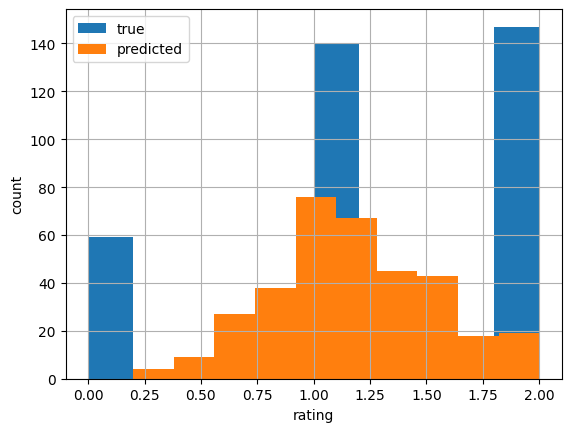

In [25]:
_ = test['Y'].hist(bins=10,label='true')
_ = test['pred'].hist(bins=10,label='predicted')
_ = plt.xlabel('rating')
_ = plt.ylabel('count')
_ = plt.legend()

### performance metrics
1. RMSE
2. MAE

In [284]:
rms = mean_squared_error(list(test.Y), list(test.pred), squared=False)
ma = mean_absolute_error(list(test.Y), list(test.pred))
print('RMSE,MAE:',rms,ma)

RMSE,MAE: 0.8062446944854885 0.6578998073217727


Given the ratings are on a narrow scale of 0-2, the magnitudes of RMSE/MAE seem to indicate that the model doesn't work very precisely; however, the error isn't too outrageous (A rating of 0 can be predicted as 0.65-0.8).

## Model 2: collaborative filtering - model-based 
### SVD

In [359]:
print('user-item interaction matrix sparsity:')
print('%.4f' % (rating.shape[0]/ (len(axis_place)*len(axis_user))),'of the matrix contains rating data')

user-item interaction matrix sparsity:
0.0647 of the matrix contains rating data


In [364]:
trainset = train[['userID','placeID','Y']]
testset = test[['userID','placeID','Y']]

In [389]:
trainset

,userID,placeID,Y
4,U1068,135104,1
5,U1068,132740,0
6,U1068,132663,1
7,U1068,132732,0
8,U1068,132630,1
...,...,...,...
1154,U1011,132564,1
1157,U1011,132715,1
1158,U1068,132733,1
1159,U1068,132594,1


In [365]:
# Surprise pkg reader for train data
reader = Reader(rating_scale=(0, 2))
data_train = Dataset.load_from_df(trainset, reader)
train_set = data_train.build_full_trainset() # use the whole training set 

### Grid search: hyper-parameter search
#### Here we search for the best hyperparameter set using train/test split, instead of setting aside a separate val set, due to the small data size.

In [409]:
n_fac = np.arange(2,100,8) 
lr = np.arange(0.001,0.01,0.001) 
reg = [0.01,0.02,0.04,0.08,0.1,0.2,0.4,0.8,1,2,4,10]

Y_pred_train = []
Y_pred_test = []

for n in n_fac:
    for l in lr:
        for r in reg:
            print('nfactor, lr, reg:',n,l,r,'\n')
            Y_pred_train = []
            Y_pred_test = []
            
            model = SVD(n_factors=n, lr_all=l, reg_all=r)
            model.train(train_set)
            
            #predict train set with model
            for i in range(trainset.shape[0]):
                pred = model.predict(trainset.userID.iloc[i], trainset.placeID.iloc[i])
                Y_pred_train.append(pred.est)

            rms = mean_squared_error(list(trainset.Y), list(Y_pred_train), squared=False)
            ma = mean_absolute_error(list(trainset.Y), list(Y_pred_train))
            print('train RMSE,MAE:',"{:.3f}".format(rms),"{:.3f}".format(ma))

            #predict test set with model    
            for i in range(testset.shape[0]):
                pred = model.predict(testset.userID.iloc[i], testset.placeID.iloc[i])
                Y_pred_test.append(pred.est)
                
            rms = mean_squared_error(list(testset.Y), list(Y_pred_test), squared=False)
            ma = mean_absolute_error(list(testset.Y), list(Y_pred_test))
            print('test RMSE,MAE:',"{:.3f}".format(rms),"{:.3f}".format(ma),'\n\n')            

nfactor, lr, reg: 2 0.001 0.01 

train RMSE,MAE: 0.711 0.618
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.02 

train RMSE,MAE: 0.711 0.617
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.04 

train RMSE,MAE: 0.711 0.617
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.08 

train RMSE,MAE: 0.711 0.618
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.1 

train RMSE,MAE: 0.711 0.619
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.2 

train RMSE,MAE: 0.712 0.618
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.4 

train RMSE,MAE: 0.713 0.619
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 0.8 

train RMSE,MAE: 0.716 0.622
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 1 

train RMSE,MAE: 0.717 0.623
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 2 

train RMSE,MAE: 0.723 0.629
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 2 0.001 4 

train RMSE,MAE: 0.733 0.637
test RMSE,MAE: 0.732 0.619 


nfactor, lr,

train RMSE,MAE: 0.643 0.556
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 2 0.008 4 

train RMSE,MAE: 0.693 0.601
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 2 0.008 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 2 0.009000000000000001 0.01 

train RMSE,MAE: 0.526 0.418
test RMSE,MAE: 0.740 0.621 


nfactor, lr, reg: 2 0.009000000000000001 0.02 

train RMSE,MAE: 0.526 0.419
test RMSE,MAE: 0.741 0.621 


nfactor, lr, reg: 2 0.009000000000000001 0.04 

train RMSE,MAE: 0.528 0.422
test RMSE,MAE: 0.740 0.621 


nfactor, lr, reg: 2 0.009000000000000001 0.08 

train RMSE,MAE: 0.531 0.427
test RMSE,MAE: 0.739 0.620 


nfactor, lr, reg: 2 0.009000000000000001 0.1 

train RMSE,MAE: 0.531 0.428
test RMSE,MAE: 0.739 0.620 


nfactor, lr, reg: 2 0.009000000000000001 0.2 

train RMSE,MAE: 0.540 0.442
test RMSE,MAE: 0.738 0.619 


nfactor, lr, reg: 2 0.009000000000000001 0.4 

train RMSE,MAE: 0.554 0.462
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 2 0.0090

test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 10 0.007 0.08 

train RMSE,MAE: 0.534 0.438
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 10 0.007 0.1 

train RMSE,MAE: 0.537 0.441
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 10 0.007 0.2 

train RMSE,MAE: 0.545 0.452
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 10 0.007 0.4 

train RMSE,MAE: 0.561 0.473
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 10 0.007 0.8 

train RMSE,MAE: 0.589 0.503
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 10 0.007 1 

train RMSE,MAE: 0.600 0.515
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 10 0.007 2 

train RMSE,MAE: 0.645 0.558
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 10 0.007 4 

train RMSE,MAE: 0.693 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 10 0.007 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 10 0.008 0.01 

train RMSE,MAE: 0.520 0.418
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 10 0.008 0.02 

train RMSE,MAE: 0.519 0.417
tes

train RMSE,MAE: 0.602 0.517
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 18 0.005 1 

train RMSE,MAE: 0.612 0.527
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 18 0.005 2 

train RMSE,MAE: 0.651 0.564
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 18 0.005 4 

train RMSE,MAE: 0.695 0.604
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 18 0.005 10 

train RMSE,MAE: 0.743 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 18 0.006 0.01 

train RMSE,MAE: 0.533 0.441
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 18 0.006 0.02 

train RMSE,MAE: 0.534 0.441
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 18 0.006 0.04 

train RMSE,MAE: 0.535 0.443
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 18 0.006 0.08 

train RMSE,MAE: 0.536 0.445
test RMSE,MAE: 0.737 0.616 


nfactor, lr, reg: 18 0.006 0.1 

train RMSE,MAE: 0.540 0.450
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 18 0.006 0.2 

train RMSE,MAE: 0.549 0.460
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 18 0.006 0.4 

tr

test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 26 0.004 0.08 

train RMSE,MAE: 0.571 0.484
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 26 0.004 0.1 

train RMSE,MAE: 0.573 0.487
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 26 0.004 0.2 

train RMSE,MAE: 0.580 0.495
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 26 0.004 0.4 

train RMSE,MAE: 0.592 0.506
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 26 0.004 0.8 

train RMSE,MAE: 0.612 0.527
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 26 0.004 1 

train RMSE,MAE: 0.622 0.536
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 26 0.004 2 

train RMSE,MAE: 0.657 0.569
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 26 0.004 4 

train RMSE,MAE: 0.697 0.606
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 26 0.004 10 

train RMSE,MAE: 0.743 0.646
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 26 0.005 0.01 

train RMSE,MAE: 0.542 0.453
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 26 0.005 0.02 

train RMSE,MAE: 0.547 0.457
tes

train RMSE,MAE: 0.745 0.648
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 34 0.003 0.01 

train RMSE,MAE: 0.596 0.510
test RMSE,MAE: 0.735 0.617 


nfactor, lr, reg: 34 0.003 0.02 

train RMSE,MAE: 0.595 0.510
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 34 0.003 0.04 

train RMSE,MAE: 0.595 0.510
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 34 0.003 0.08 

train RMSE,MAE: 0.596 0.510
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 34 0.003 0.1 

train RMSE,MAE: 0.596 0.511
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 34 0.003 0.2 

train RMSE,MAE: 0.605 0.519
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 34 0.003 0.4 

train RMSE,MAE: 0.613 0.528
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 34 0.003 0.8 

train RMSE,MAE: 0.631 0.545
test RMSE,MAE: 0.733 0.616 


nfactor, lr, reg: 34 0.003 1 

train RMSE,MAE: 0.637 0.551
test RMSE,MAE: 0.732 0.616 


nfactor, lr, reg: 34 0.003 2 

train RMSE,MAE: 0.667 0.578
test RMSE,MAE: 0.731 0.616 


nfactor, lr, reg: 34 0.003 4 

t

test RMSE,MAE: 0.733 0.619 


nfactor, lr, reg: 42 0.001 0.1 

train RMSE,MAE: 0.704 0.610
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.2 

train RMSE,MAE: 0.703 0.609
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.4 

train RMSE,MAE: 0.706 0.611
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.8 

train RMSE,MAE: 0.710 0.616
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 1 

train RMSE,MAE: 0.708 0.616
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 2 

train RMSE,MAE: 0.716 0.623
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 4 

train RMSE,MAE: 0.730 0.635
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 10 

train RMSE,MAE: 0.751 0.652
test RMSE,MAE: 0.732 0.620 


nfactor, lr, reg: 42 0.002 0.01 

train RMSE,MAE: 0.635 0.548
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 42 0.002 0.02 

train RMSE,MAE: 0.635 0.548
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 42 0.002 0.04 

train RMSE,MAE: 0.635 0.549
tes

train RMSE,MAE: 0.456 0.362
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.04 

train RMSE,MAE: 0.463 0.371
test RMSE,MAE: 0.742 0.621 


nfactor, lr, reg: 42 0.009000000000000001 0.08 

train RMSE,MAE: 0.467 0.376
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.1 

train RMSE,MAE: 0.473 0.382
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.2 

train RMSE,MAE: 0.496 0.407
test RMSE,MAE: 0.738 0.619 


nfactor, lr, reg: 42 0.009000000000000001 0.4 

train RMSE,MAE: 0.531 0.444
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 42 0.009000000000000001 0.8 

train RMSE,MAE: 0.573 0.488
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 42 0.009000000000000001 1 

train RMSE,MAE: 0.589 0.504
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 42 0.009000000000000001 2 

train RMSE,MAE: 0.641 0.554
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 42 0.009000000000000001 4 

train RMSE,MAE: 0.692 0.601
test RMSE,MAE: 0.731 0

train RMSE,MAE: 0.594 0.510
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 50 0.007 2 

train RMSE,MAE: 0.643 0.557
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 50 0.007 4 

train RMSE,MAE: 0.693 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 50 0.007 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 50 0.008 0.01 

train RMSE,MAE: 0.455 0.365
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 50 0.008 0.02 

train RMSE,MAE: 0.458 0.368
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.04 

train RMSE,MAE: 0.462 0.372
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 50 0.008 0.08 

train RMSE,MAE: 0.472 0.384
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 50 0.008 0.1 

train RMSE,MAE: 0.479 0.391
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.2 

train RMSE,MAE: 0.501 0.413
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 50 0.008 0.4 

train RMSE,MAE: 0.533 0.446
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.8 



train RMSE,MAE: 0.493 0.407
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 58 0.006 0.08 

train RMSE,MAE: 0.496 0.411
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 58 0.006 0.1 

train RMSE,MAE: 0.505 0.418
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 58 0.006 0.2 

train RMSE,MAE: 0.520 0.435
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 58 0.006 0.4 

train RMSE,MAE: 0.545 0.461
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 58 0.006 0.8 

train RMSE,MAE: 0.582 0.498
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 58 0.006 1 

train RMSE,MAE: 0.597 0.513
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 58 0.006 2 

train RMSE,MAE: 0.645 0.558
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 58 0.006 4 

train RMSE,MAE: 0.694 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 58 0.006 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 58 0.007 0.01 

train RMSE,MAE: 0.462 0.375
test RMSE,MAE: 0.738 0.617 


nfactor, lr, reg: 58 0.007 0.02 

tra

train RMSE,MAE: 0.612 0.528
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 66 0.004 2 

train RMSE,MAE: 0.654 0.566
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 66 0.004 4 

train RMSE,MAE: 0.697 0.605
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 66 0.004 10 

train RMSE,MAE: 0.743 0.646
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 66 0.005 0.01 

train RMSE,MAE: 0.506 0.423
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 66 0.005 0.02 

train RMSE,MAE: 0.499 0.417
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 66 0.005 0.04 

train RMSE,MAE: 0.508 0.426
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 66 0.005 0.08 

train RMSE,MAE: 0.513 0.430
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 66 0.005 0.1 

train RMSE,MAE: 0.515 0.432
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 66 0.005 0.2 

train RMSE,MAE: 0.531 0.448
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 66 0.005 0.4 

train RMSE,MAE: 0.553 0.470
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 66 0.005 0.8 



train RMSE,MAE: 0.569 0.487
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.08 

train RMSE,MAE: 0.574 0.492
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 74 0.003 0.1 

train RMSE,MAE: 0.574 0.493
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 74 0.003 0.2 

train RMSE,MAE: 0.585 0.501
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.4 

train RMSE,MAE: 0.596 0.512
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.8 

train RMSE,MAE: 0.616 0.533
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 74 0.003 1 

train RMSE,MAE: 0.626 0.541
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 74 0.003 2 

train RMSE,MAE: 0.662 0.574
test RMSE,MAE: 0.731 0.616 


nfactor, lr, reg: 74 0.003 4 

train RMSE,MAE: 0.700 0.608
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 74 0.003 10 

train RMSE,MAE: 0.744 0.646
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 74 0.004 0.01 

train RMSE,MAE: 0.530 0.449
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 74 0.004 0.02 

tra

train RMSE,MAE: 0.704 0.612
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 1 

train RMSE,MAE: 0.704 0.610
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 2 

train RMSE,MAE: 0.713 0.620
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 4 

train RMSE,MAE: 0.727 0.631
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 10 

train RMSE,MAE: 0.750 0.652
test RMSE,MAE: 0.732 0.620 


nfactor, lr, reg: 82 0.002 0.01 

train RMSE,MAE: 0.619 0.533
test RMSE,MAE: 0.732 0.616 


nfactor, lr, reg: 82 0.002 0.02 

train RMSE,MAE: 0.616 0.531
test RMSE,MAE: 0.733 0.617 


nfactor, lr, reg: 82 0.002 0.04 

train RMSE,MAE: 0.618 0.532
test RMSE,MAE: 0.733 0.617 


nfactor, lr, reg: 82 0.002 0.08 

train RMSE,MAE: 0.622 0.534
test RMSE,MAE: 0.732 0.616 


nfactor, lr, reg: 82 0.002 0.1 

train RMSE,MAE: 0.622 0.537
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 82 0.002 0.2 

train RMSE,MAE: 0.627 0.542
test RMSE,MAE: 0.732 0.617 


nfactor, lr, reg: 82 0.002 0.4 

tr

train RMSE,MAE: 0.406 0.325
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 82 0.009000000000000001 0.08 

train RMSE,MAE: 0.421 0.339
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 82 0.009000000000000001 0.1 

train RMSE,MAE: 0.428 0.346
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 82 0.009000000000000001 0.2 

train RMSE,MAE: 0.466 0.382
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 82 0.009000000000000001 0.4 

train RMSE,MAE: 0.508 0.425
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 82 0.009000000000000001 0.8 

train RMSE,MAE: 0.566 0.482
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 82 0.009000000000000001 1 

train RMSE,MAE: 0.583 0.499
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 82 0.009000000000000001 2 

train RMSE,MAE: 0.640 0.553
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 82 0.009000000000000001 4 

train RMSE,MAE: 0.692 0.601
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 82 0.009000000000000001 10 

train RMSE,MAE: 0.742 0.644
test RMSE,MAE: 0.731 0.6

train RMSE,MAE: 0.569 0.487
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 90 0.007 1 

train RMSE,MAE: 0.588 0.504
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 90 0.007 2 

train RMSE,MAE: 0.642 0.555
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 90 0.007 4 

train RMSE,MAE: 0.693 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 90 0.007 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 90 0.008 0.01 

train RMSE,MAE: 0.399 0.321
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 90 0.008 0.02 

train RMSE,MAE: 0.404 0.325
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 90 0.008 0.04 

train RMSE,MAE: 0.419 0.337
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 90 0.008 0.08 

train RMSE,MAE: 0.430 0.348
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 90 0.008 0.1 

train RMSE,MAE: 0.430 0.350
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 90 0.008 0.2 

train RMSE,MAE: 0.462 0.381
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 90 0.008 0.4 

tr

test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 98 0.006 0.08 

train RMSE,MAE: 0.463 0.383
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 98 0.006 0.1 

train RMSE,MAE: 0.460 0.384
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 98 0.006 0.2 

train RMSE,MAE: 0.488 0.410
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 98 0.006 0.4 

train RMSE,MAE: 0.524 0.444
test RMSE,MAE: 0.736 0.618 


nfactor, lr, reg: 98 0.006 0.8 

train RMSE,MAE: 0.572 0.489
test RMSE,MAE: 0.733 0.614 


nfactor, lr, reg: 98 0.006 1 

train RMSE,MAE: 0.589 0.506
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 98 0.006 2 

train RMSE,MAE: 0.644 0.557
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 98 0.006 4 

train RMSE,MAE: 0.694 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 98 0.006 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 98 0.007 0.01 

train RMSE,MAE: 0.409 0.331
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 98 0.007 0.02 

train RMSE,MAE: 0.417 0.340
tes

# Conclusion
Through the grid search, we found that the performance on test set is almost always with RMSE ~ 0.73 AND MAE ~ 0.62, although the train set performance differs a lot.
In a lot of cases, the test error is much greater than train error, which could imply that those hyperparameters suffer from overfitting.
Indeed, with the small data size (~O(10^3)) / a very sparse matrix (6% of the matrix contains rating), the model can likely suffer overfitting. In the parameter sets that have similar RMSE/MAE for train and test, the error is slightly smaller than model 1 (memory-based collaborative filtering).
SVD is likely a better model than hand-picking similarity features, if given a better data size.